In [1]:
# Fine-tuning de BERT para detección de textos tóxicos

import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizerFast, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


Usando dispositivo: cuda


C:\Users\Jhon\anaconda3\envs\facef\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
C:\Users\Jhon\anaconda3\envs\facef\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'b

# Fine-tuning de BERT para detección de textos tóxicos

A pesar de que el enunciado del problema especifica el uso de modelos basados en árboles de decisión, la exploración de un modelo BERT fine-tuneado representa un valor añadido para el proyecto:

- Aunque BERT puede requerir más recursos computacionales, su inclusión en el análisis proporciona un punto de comparación valioso contra los modelos tradicionales.
- Puede capturar contextos complejos y matices lingüísticos sutiles, que pueden ser cruciales en la identificación de lenguaje ofensivo indirecto o sarcástico.
- Habilidad para manejar palabras desconocidas y variaciones lingüísticas que puede mejorar la robustez ante formas desconocidas de expresión tóxica.
- El uso de BERT puede resultar en insights adicionales y potencialmente en una solución más efectiva y adaptable a largo plazo para la detección de toxicidad en textos.

Esta exploración adicional nos podria dar una vision mas completa para este problema específico de detección de textos tóxicos.


In [ ]:
# Configuración de dispositivo (GPU si está disponible, sino CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Cargar los datos
df = pd.read_csv('../data/processed/data_toxic_features.csv')

# Dividir los datos en entrenamiento y prueba
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['message'], df['label'], test_size=0.2, random_state=42
)

# Cargar el tokenizador y el modelo BERT preentrenado en español
model_name = "dccuchile/bert-base-spanish-wwm-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

In [2]:
# Tokenizar los textos
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=512)

# Crear datasets y dataloaders
train_dataset = TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels.tolist())
)
test_dataset = TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask']),
    torch.tensor(test_labels.tolist())
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Configurar el optimizador
optimizer = AdamW(model.parameters(), lr=2e-5)

# Función de entrenamiento
def train(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Entrenando"):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    return total_loss / len(dataloader)

# Función de evaluación
def evaluate(model, dataloader, device):
    model.eval()
    predictions = []
    real_labels = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluando"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            predictions.extend(preds.cpu().tolist())
            real_labels.extend(labels.cpu().tolist())
    return classification_report(real_labels, predictions), confusion_matrix(real_labels, predictions)



C:\Users\Jhon\anaconda3\envs\facef\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Época 1/3


Entrenando: 100%|████████████████████████████████████████████████████████| 24105/24105 [4:30:14<00:00,  1.49it/s]


Pérdida de entrenamiento: 0.0942
Época 2/3


Entrenando: 100%|██████████████████████████████████████████████████████████████| 24105/24105 [4:31:05<00:00,  1.48it/s]


Pérdida de entrenamiento: 0.0822
Época 3/3


Entrenando: 100%|██████████████████████████████████████████████████████████████| 24105/24105 [4:31:32<00:00,  1.48it/s]


Pérdida de entrenamiento: 0.0738
Evaluando el modelo...


Evaluando: 100%|███████████████████████████████████████████████████████████████████| 6027/6027 [24:00<00:00,  4.18it/s]


Informe de clasificación:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     57781
           1       0.98      0.94      0.96     38637

    accuracy                           0.97     96418
   macro avg       0.97      0.97      0.97     96418
weighted avg       0.97      0.97      0.97     96418



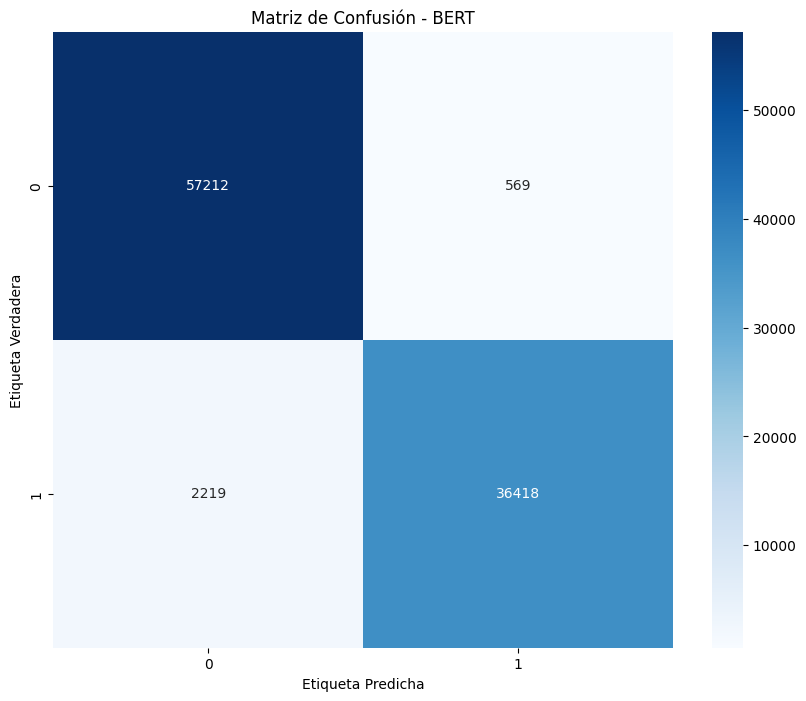

Modelo BERT fine-tuneado guardado en '../models/bert_finetuned'
Texto: 'Eres un idiota y no sabes nada.'
Predicción: Tóxico
Probabilidad de toxicidad: 0.9996


In [3]:
# Entrenar el modelo
num_epochs = 3
for epoch in range(num_epochs):
    print(f"Época {epoch + 1}/{num_epochs}")
    train_loss = train(model, train_loader, optimizer, device)
    print(f"Pérdida de entrenamiento: {train_loss:.4f}")
    
    if epoch == num_epochs - 1:  # Evaluar solo en la última época para ahorrar tiempo
        print("Evaluando el modelo...")
        report, cm = evaluate(model, test_loader, device)
        print("Informe de clasificación:")
        print(report)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - BERT')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.show()

# Guardar el modelo fine-tuneado
model.save_pretrained('../models/bert_finetuned')
tokenizer.save_pretrained('../models/bert_finetuned')
print("Modelo BERT fine-tuneado guardado en '../models/bert_finetuned'")

# Función para predecir la toxicidad de un texto
def predict_toxicity(text, model, tokenizer, device):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    probabilities = torch.softmax(outputs.logits, dim=1)
    prediction = torch.argmax(probabilities, dim=1).item()
    toxicity_prob = probabilities[0][1].item()
    return prediction, toxicity_prob

# Ejemplo de uso
example_text = "Eres un idiota y no sabes nada."
prediction, toxicity_prob = predict_toxicity(example_text, model, tokenizer, device)
print(f"Texto: '{example_text}'")
print(f"Predicción: {'Tóxico' if prediction == 1 else 'No tóxico'}")
print(f"Probabilidad de toxicidad: {toxicity_prob:.4f}")